In [21]:
import numpy as np
import matplotlib.pyplot as plt

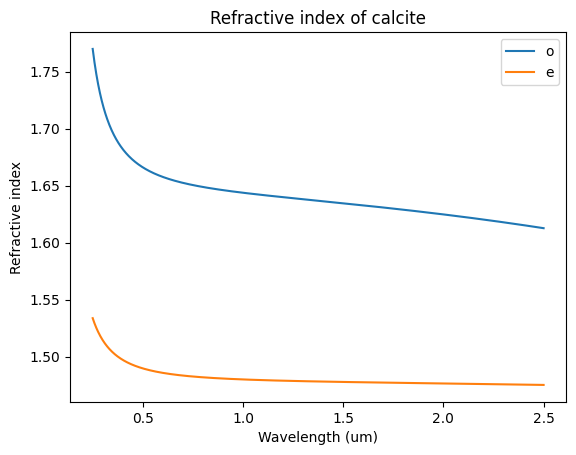

In [22]:
def calcite_sellmeier_n(wavelength, axis="o"):
    """
    Sellmeier equation for calcite crystal
    https://refractiveindex.info
    Ghosh 1999
    """
    if axis == "o":
        A = 1.73358749
        B = 0.96464345
        C = 1.94325203e-2
        D = 1.82831454
        E = 120
    elif axis == "e":
        A = 1.35859695
        B = 0.82427830
        C = 1.06689543e-2
        D = 0.14429128
        E = 120

    n2 = A + B * wavelength**2 / (wavelength**2 - C) + D * wavelength**2 / (wavelength**2 - E)
    return np.sqrt(n2)


# plot the refractive index of calcite
wavelength = np.linspace(0.25, 2.5, 1000)
n_o = calcite_sellmeier_n(wavelength, "o")
n_e = calcite_sellmeier_n(wavelength, "e")
plt.plot(wavelength, n_o)
plt.plot(wavelength, n_e)
plt.legend(["o", "e"])
plt.xlabel("Wavelength (um)")
plt.ylabel("Refractive index")
plt.title("Refractive index of calcite")
plt.show()

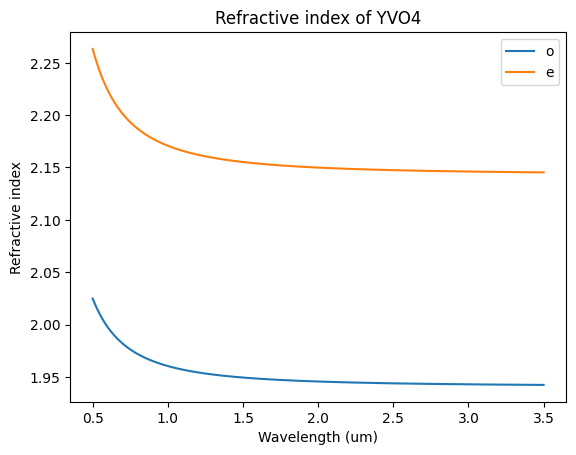

In [23]:
def yvo_sellmeier_n(wavelength, axis='o'):
    """
    Sellmeier equation for YVO4 crystal
    https://refractiveindex.info
    Birnbaum et al., 1976
    """
    if axis == 'o':
        A = 1
        B = 2.7665
        C = 0.026884
    elif axis == 'e':
        A = 1
        B = 3.5930
        C = 0.032103
    n2 = A + B * wavelength**2 / (wavelength**2 - C)
    return np.sqrt(n2)

# plot the refractive index of YVO4
wavelength = np.linspace(0.5, 3.5, 1000)
n_o = yvo_sellmeier_n(wavelength, 'o')
n_e = yvo_sellmeier_n(wavelength, 'e')
plt.plot(wavelength, n_o)
plt.plot(wavelength, n_e)
plt.legend(['o', 'e'])
plt.xlabel('Wavelength (um)')
plt.ylabel('Refractive index')
plt.title('Refractive index of YVO4')
plt.show()

In [24]:
def get_phase(n, thickness, wavelength):
    return 2 * np.pi * n * thickness / wavelength

def calcite_sellmeier_n_eff(wavelength, theta=np.pi/4):
    """
    Effective refractive index of calcite
    """
    no = calcite_sellmeier_n(wavelength, 'o')
    ne = calcite_sellmeier_n(wavelength, 'e')
    n = np.sqrt(no**2 * np.sin(theta)**2 + ne**2 * np.cos(theta)**2)
    return n

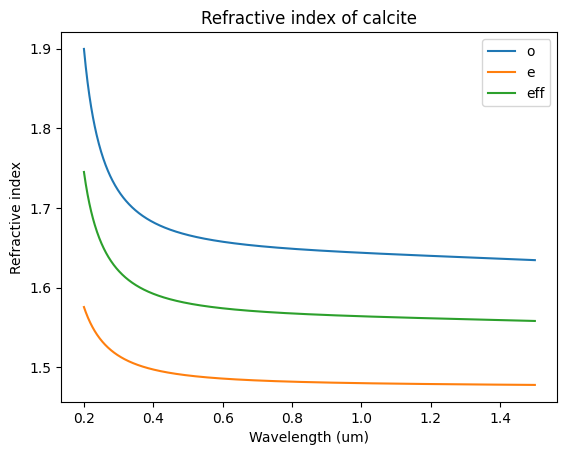

In [25]:
# plot the refractive index of calcite 
wavelength = np.linspace(0.2, 1.5, 1000)
n_o = calcite_sellmeier_n(wavelength, 'o')
n_e = calcite_sellmeier_n(wavelength, 'e')
n_eff = calcite_sellmeier_n_eff(wavelength)
plt.plot(wavelength, n_o)
plt.plot(wavelength, n_e)
plt.plot(wavelength, n_eff)
plt.legend(['o', 'e', 'eff'])
plt.xlabel('Wavelength (um)')
plt.ylabel('Refractive index')
plt.title('Refractive index of calcite')
plt.show()

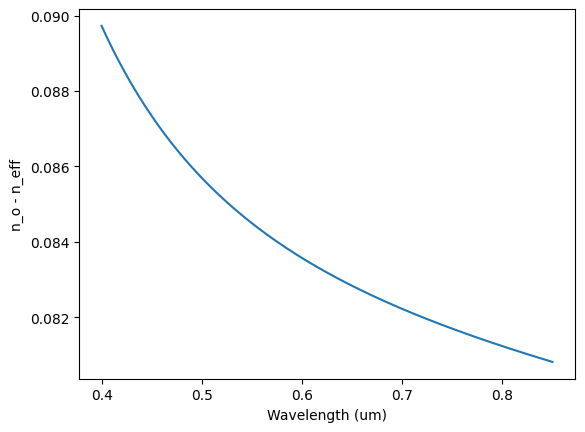

In [26]:
wavelength = np.linspace(0.4, 0.85, 1000)
n_o = calcite_sellmeier_n(wavelength, 'o')
n_e = calcite_sellmeier_n(wavelength, 'e')
n_eff = calcite_sellmeier_n_eff(wavelength)

plt.plot(wavelength, n_o - n_eff)

plt.xlabel("Wavelength (um)")
plt.ylabel("n_o - n_eff", )
plt.show()

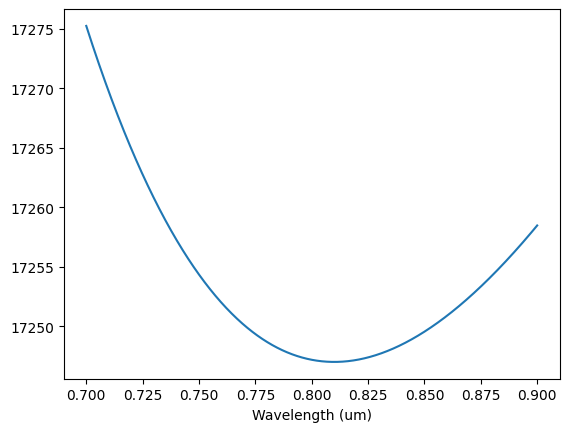

In [27]:
wavelength = np.linspace(0.7, 0.9, 1000)
n_o = calcite_sellmeier_n(wavelength, "o")
n_eff = calcite_sellmeier_n_eff(wavelength)

phase_1 = (n_o - n_eff) / wavelength

pump_wavelength = 0.405  # um
s_wavelength = 1 / (1 / pump_wavelength - 1 / wavelength)

n_o = calcite_sellmeier_n(s_wavelength, "o")
n_eff = calcite_sellmeier_n_eff(s_wavelength)
phase_2 = (n_o - n_eff) / s_wavelength

# plt.plot(wavelength, phase_1)
# plt.plot(wavelength, phase_2)

total_phase = (phase_1 + phase_2) * 2 * np.pi * 13.7e3 

plt.plot(wavelength, total_phase)
plt.xlabel("Wavelength (um)")
plt.show()

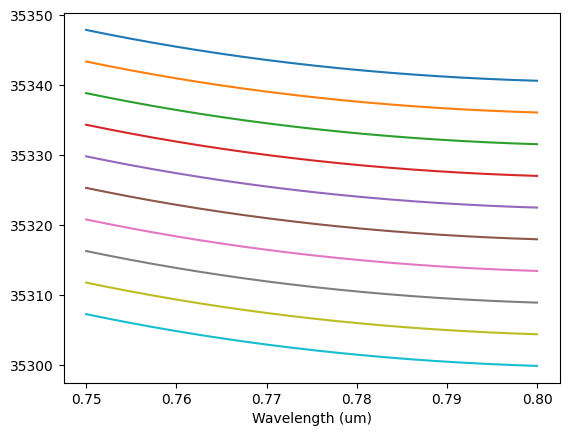

In [28]:
for pump_wavelength in np.linspace(0.4052, 0.4056, 10):
    wavelength = np.linspace(0.75, 0.8, 1000)
    n_o_1 = calcite_sellmeier_n(wavelength, "o")
    n_eff_1 = calcite_sellmeier_n_eff(wavelength)

    phase_1 = 2 * np.pi * (n_o_1 - n_eff_1) / wavelength

    s_wavelength = 1 / (1 / pump_wavelength - 1 / wavelength)

    n_o_2 = calcite_sellmeier_n(s_wavelength, "o")
    n_eff_2 = calcite_sellmeier_n_eff(s_wavelength)
    phase_2 = 2 * np.pi * (n_o_2 - n_eff_2) / s_wavelength

    # plt.plot(wavelength, phase_1)
    # plt.plot(wavelength, phase_2)

    n_o_p = calcite_sellmeier_n(pump_wavelength, "o")
    n_eff_p = calcite_sellmeier_n_eff(pump_wavelength)
    pump_phase = 2 * np.pi * (n_o_p - n_eff_p) / pump_wavelength

    total_phase = (phase_1 + phase_2) * 13.76e3 + pump_phase * 13e3

    plt.plot(wavelength, total_phase)
    plt.xlabel("Wavelength (um)")
plt.show()

# Adding Compensation

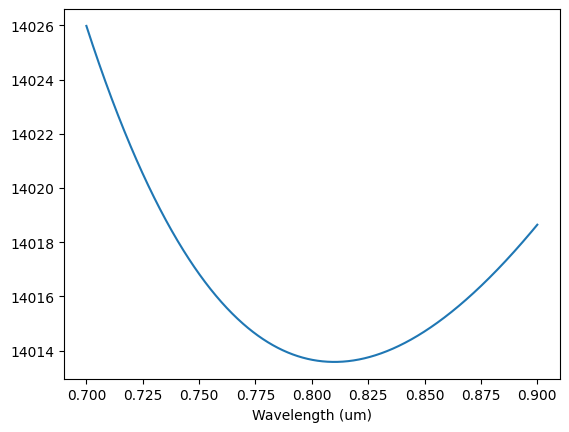

In [29]:
wavelength = np.linspace(0.7, 0.9, 1000)
n_o_1 = calcite_sellmeier_n(wavelength, "o")
n_eff_1 = calcite_sellmeier_n_eff(wavelength)
phase_1 = 2 * np.pi * (n_o_1 - n_eff_1) / wavelength * 13.7e3

pump_wavelength = 0.405  # um
s_wavelength = 1 / (1 / pump_wavelength - 1 / wavelength)

n_o_2 = calcite_sellmeier_n(s_wavelength, "o")
n_eff_2 = calcite_sellmeier_n_eff(s_wavelength)
phase_2 = 2 * np.pi * (n_o_2 - n_eff_2) / s_wavelength * 13.7e3


n_o_yvo_i = yvo_sellmeier_n(wavelength, "o")
n_e_yvo_i = yvo_sellmeier_n(wavelength, "e")

n_o_yvo_s = yvo_sellmeier_n(s_wavelength, "o")
n_e_yvo_s = yvo_sellmeier_n(s_wavelength, "e")

post_compensation_phase = (
    2
    * np.pi
    * (
        n_o_yvo_i / wavelength
        + n_o_yvo_s / s_wavelength
        - n_e_yvo_i / wavelength
        - n_e_yvo_s / s_wavelength
    )
) * 0.97e3

total_phase = (phase_1 + phase_2 + post_compensation_phase)


plt.plot(wavelength, total_phase)
plt.xlabel("Wavelength (um)")
plt.show()


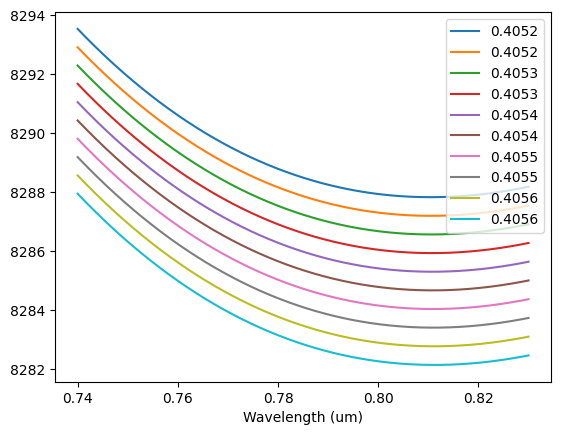

In [30]:
for pump_wavelength in np.linspace(0.4052, 0.4056, 10):
    wavelength = np.linspace(0.74, 0.83, 1000)
    n_o_1 = calcite_sellmeier_n(wavelength, "o")
    n_eff_1 = calcite_sellmeier_n_eff(wavelength)
    phase_1 = 2 * np.pi * (n_o_1 - n_eff_1) / wavelength * 13.7e3

    s_wavelength = 1 / (1 / pump_wavelength - 1 / wavelength)

    n_o_2 = calcite_sellmeier_n(s_wavelength, "o")
    n_eff_2 = calcite_sellmeier_n_eff(s_wavelength)
    phase_2 = 2 * np.pi * (n_o_2 - n_eff_2) / s_wavelength * 13.7e3

    n_o_yvo_i = yvo_sellmeier_n(wavelength, "o")
    n_e_yvo_i = yvo_sellmeier_n(wavelength, "e")

    n_o_yvo_s = yvo_sellmeier_n(s_wavelength, "o")
    n_e_yvo_s = yvo_sellmeier_n(s_wavelength, "e")

    n_o_yvo_p = yvo_sellmeier_n(pump_wavelength, "o")
    n_e_yvo_p = yvo_sellmeier_n(pump_wavelength, "e")

    pre_compensation_phase = (
        2 * np.pi * (n_o_yvo_p - n_e_yvo_p) / pump_wavelength
    ) * 1.56e3 # 0.78e3

    post_compensation_phase = (
        2
        * np.pi
        * (
            n_o_yvo_i / wavelength
            + n_o_yvo_s / s_wavelength
            - n_e_yvo_i / wavelength
            - n_e_yvo_s / s_wavelength
        )
    ) * 0.78e3 # 0.97e3

    n_o_p = calcite_sellmeier_n(pump_wavelength, "o")
    n_eff_p = calcite_sellmeier_n_eff(pump_wavelength)
    pump_phase = 2 * np.pi * (n_o_p - n_eff_p) / pump_wavelength * 13e3

    pump_phase = 2 * np.pi * (n_o_yvo_p - n_e_yvo_p) / pump_wavelength

    total_phase = (phase_1 + phase_2 + pre_compensation_phase + post_compensation_phase + pump_phase)


    plt.plot(wavelength, total_phase, label=f"{pump_wavelength:.4f}")
    plt.xlabel("Wavelength (um)")
plt.legend()
plt.show()


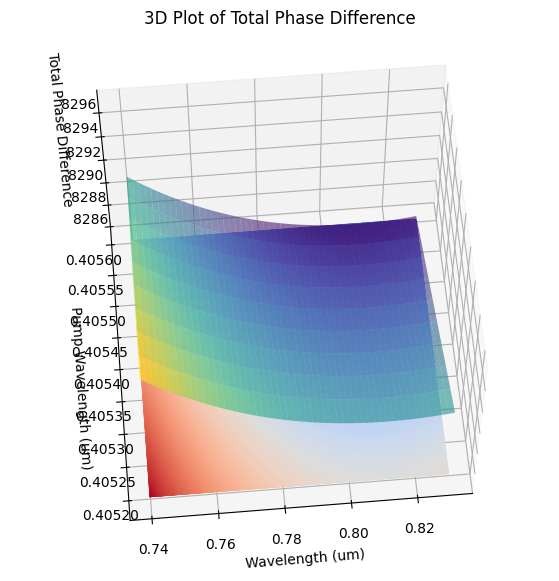

In [31]:
# Generate data for 3D plot
pump_wavelengths = np.linspace(0.4052, 0.4056, 10)
wavelengths = np.linspace(0.74, 0.83, 1000)
X, Y = np.meshgrid(wavelengths, pump_wavelengths)
Z = np.zeros_like(X)

for i, pump_wavelength in enumerate(pump_wavelengths):
    n_o_1 = calcite_sellmeier_n(wavelengths, "o")
    n_eff_1 = calcite_sellmeier_n_eff(wavelengths)
    phase_1 = 2 * np.pi * (n_o_1 - n_eff_1) / wavelengths * 13.7e3

    s_wavelengths = 1 / (1 / pump_wavelength - 1 / wavelengths)

    n_o_2 = calcite_sellmeier_n(s_wavelengths, "o")
    n_eff_2 = calcite_sellmeier_n_eff(s_wavelengths)
    phase_2 = 2 * np.pi * (n_o_2 - n_eff_2) / s_wavelengths * 13.7e3

    n_o_yvo_i = yvo_sellmeier_n(wavelengths, "o")
    n_e_yvo_i = yvo_sellmeier_n(wavelengths, "e")
    n_o_yvo_s = yvo_sellmeier_n(s_wavelengths, "o")
    n_e_yvo_s = yvo_sellmeier_n(s_wavelengths, "e")
    n_o_yvo_p = yvo_sellmeier_n(pump_wavelength, "o")
    n_e_yvo_p = yvo_sellmeier_n(pump_wavelength, "e")

    pre_compensation_phase = (
        2 * np.pi * (n_o_yvo_p - n_e_yvo_p) / pump_wavelength
    ) * 1.56e3 

    post_compensation_phase = (
        2
        * np.pi
        * (
            n_o_yvo_i / wavelengths
            + n_o_yvo_s / s_wavelengths
            - n_e_yvo_i / wavelengths
            - n_e_yvo_s / s_wavelengths
        )
    ) * 0.78e3

    n_o_p = calcite_sellmeier_n(pump_wavelength, "o")
    n_eff_p = calcite_sellmeier_n_eff(pump_wavelength)
    pump_phase = 2 * np.pi * (n_o_p - n_eff_p) / pump_wavelength * 13e3


    Z[i, :] = (phase_1 + phase_2 + pre_compensation_phase + post_compensation_phase) # + pump_phase)

# Create 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.6)
ax.contour(X, Y, Z, levels=np.arange(Z.min(), Z.max(), 0.005), cmap='coolwarm', offset=Z.min())
ax.set_xlabel("Wavelength (um)")
ax.set_ylabel("Pump Wavelength (um)")
ax.set_zlabel("Total Phase Difference")
ax.set_title("3D Plot of Total Phase Difference")
ax.view_init(elev=60, azim=265)  # Adjusted viewing angle

plt.show()


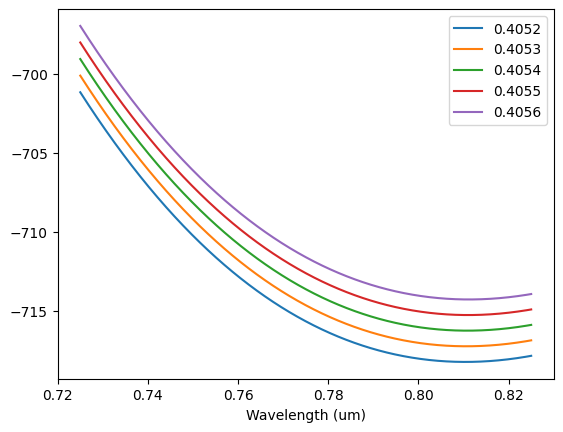

In [32]:
l_yvo_pre = 0 # 0.78e3 # um
l_calcite_pre = 12.5e3 # um
l_calcite_post = 13.3e3 # um
l_yvo_post = 0 # 0.97e3 # um

a = 'o'
aprime = 'e'

b = 'e'
bprime = 'o'

for pump_wavelength in np.linspace(0.4052, 0.4056, 5):
    s_wavelength = np.linspace(0.725, 0.825, 1000) # um
    i_wavelength = 1 / (1 / pump_wavelength - 1 / s_wavelength) # um

    n_a_yvo_p = yvo_sellmeier_n(pump_wavelength, a)
    n_o_calcite_p = calcite_sellmeier_n(pump_wavelength, b)
    n_eff_calcite_i = calcite_sellmeier_n_eff(i_wavelength)
    n_eff_calcite_s = calcite_sellmeier_n_eff(s_wavelength)
    n_b_yvo_i = yvo_sellmeier_n(i_wavelength, b)
    n_b_yvo_s = yvo_sellmeier_n(s_wavelength, b)
    n_aprime_yvo_p = yvo_sellmeier_n(pump_wavelength, aprime)
    n_eff_calcite_p = calcite_sellmeier_n_eff(pump_wavelength)
    n_o_calcite_i = calcite_sellmeier_n(i_wavelength, b)
    n_o_calcite_s = calcite_sellmeier_n(s_wavelength, b)
    n_bprime_yvo_i = yvo_sellmeier_n(i_wavelength, bprime)
    n_bprime_yvo_s = yvo_sellmeier_n(s_wavelength, bprime)

    phase_h = 2 * np.pi * (
        l_yvo_pre  * n_a_yvo_p   / pump_wavelength + 
        l_calcite_pre  * n_o_calcite_p   / pump_wavelength +
        l_calcite_post * n_eff_calcite_i / i_wavelength +
        l_calcite_post * n_eff_calcite_s / s_wavelength +
        l_yvo_post * n_b_yvo_i   / i_wavelength +
        l_yvo_post * n_b_yvo_s   / s_wavelength
    )

    phase_v = 2 * np.pi * (
        l_yvo_pre  * n_aprime_yvo_p / pump_wavelength + 
        l_calcite_pre  * n_eff_calcite_p    / pump_wavelength +
        l_calcite_post * n_o_calcite_i      / i_wavelength +
        l_calcite_post * n_o_calcite_s      / s_wavelength +
        l_yvo_post * n_bprime_yvo_i / i_wavelength +
        l_yvo_post * n_bprime_yvo_s / s_wavelength
    )

    total_phase = phase_h - phase_v

    plt.plot(s_wavelength, total_phase, label=f"{pump_wavelength:.4f}")
plt.xlabel("Wavelength (um)")
plt.legend()
plt.show()

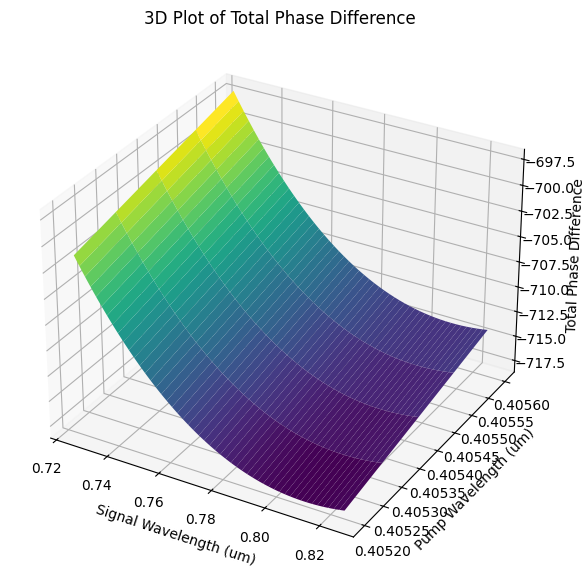

In [33]:
# Define optical path lengths (in um)
l_yvo_pre = 0
l_calcite_pre = 12.5e3 # um
l_calcite_post = 13.3e3 # um
l_yvo_post = 0

# Define polarization states
a = 'o'
aprime = 'e'
b = 'e'
bprime = 'o'

# Generate data for 3D plot
pump_wavelengths = np.linspace(0.4052, 0.4056, 5)
s_wavelengths = np.linspace(0.725, 0.825, 1000)
X, Y = np.meshgrid(s_wavelengths, pump_wavelengths)
Z = np.zeros_like(X)

for i, pump_wavelength in enumerate(pump_wavelengths):
    i_wavelengths = 1 / (1 / pump_wavelength - 1 / s_wavelengths)
    
    n_a_yvo_p = yvo_sellmeier_n(pump_wavelength, a)
    n_o_calcite_p = calcite_sellmeier_n(pump_wavelength, b)
    n_eff_calcite_i = calcite_sellmeier_n_eff(i_wavelengths)
    n_eff_calcite_s = calcite_sellmeier_n_eff(s_wavelengths)
    n_b_yvo_i = yvo_sellmeier_n(i_wavelengths, b)
    n_b_yvo_s = yvo_sellmeier_n(s_wavelengths, b)
    n_aprime_yvo_p = yvo_sellmeier_n(pump_wavelength, aprime)
    n_eff_calcite_p = calcite_sellmeier_n_eff(pump_wavelength)
    n_o_calcite_i = calcite_sellmeier_n(i_wavelengths, b)
    n_o_calcite_s = calcite_sellmeier_n(s_wavelengths, b)
    n_bprime_yvo_i = yvo_sellmeier_n(i_wavelengths, bprime)
    n_bprime_yvo_s = yvo_sellmeier_n(s_wavelengths, bprime)

    phase_h = 2 * np.pi * (
        l_yvo_pre  * n_a_yvo_p   / pump_wavelength + 
        l_calcite_pre  * n_o_calcite_p   / pump_wavelength +
        l_calcite_post * n_eff_calcite_i / i_wavelengths +
        l_calcite_post * n_eff_calcite_s / s_wavelengths +
        l_yvo_post * n_b_yvo_i   / i_wavelengths +
        l_yvo_post * n_b_yvo_s   / s_wavelengths
    )

    phase_v = 2 * np.pi * (
        l_yvo_pre  * n_aprime_yvo_p / pump_wavelength + 
        l_calcite_pre  * n_eff_calcite_p    / pump_wavelength +
        l_calcite_post * n_o_calcite_i      / i_wavelengths +
        l_calcite_post * n_o_calcite_s      / s_wavelengths +
        l_yvo_post * n_bprime_yvo_i / i_wavelengths +
        l_yvo_post * n_bprime_yvo_s / s_wavelengths
    )
    
    Z[i, :] = phase_h - phase_v

# Create 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')
ax.set_xlabel("Signal Wavelength (um)")
ax.set_ylabel("Pump Wavelength (um)")
ax.set_zlabel("Total Phase Difference")
ax.set_title("3D Plot of Total Phase Difference")

plt.show()


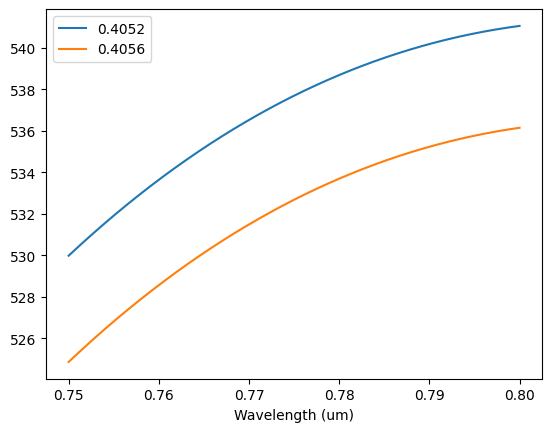

In [34]:
l_yvo_pre = 0.78e3 #0.78e3 # um
l_calcite_pre = 12.5e3 # um
l_calcite_post = 13.3e3 # um
l_yvo_post = 0.97e3 # um

a = 'e'
aprime = 'o'

b = 'o'
bprime = 'e'

for pump_wavelength in np.linspace(0.4052, 0.4056, 2):
    s_wavelength = np.linspace(0.75, 0.8, 1000) # um
    i_wavelength = 1 / (1 / pump_wavelength - 1 / s_wavelength) # um

    # "H"
    n_a_yvo_p   = yvo_sellmeier_n(pump_wavelength, a)
    n_o_calcite_p   = calcite_sellmeier_n(pump_wavelength, "o")
    n_eff_calcite_i = calcite_sellmeier_n_eff(i_wavelength)
    n_eff_calcite_s = calcite_sellmeier_n_eff(s_wavelength)
    n_b_yvo_i   = yvo_sellmeier_n(i_wavelength, b)
    n_b_yvo_s   = yvo_sellmeier_n(s_wavelength, b)

    # "V"
    n_aprime_yvo_p = yvo_sellmeier_n(pump_wavelength, aprime)
    n_eff_calcite_p    = calcite_sellmeier_n_eff(pump_wavelength)
    n_o_calcite_i      = calcite_sellmeier_n(i_wavelength, "o")
    n_o_calcite_s      = calcite_sellmeier_n(s_wavelength, "o")
    n_bprime_yvo_i = yvo_sellmeier_n(i_wavelength, bprime)
    n_bprime_yvo_s = yvo_sellmeier_n(s_wavelength, bprime)

    phase_h = 2 * np.pi * (
        l_yvo_pre  * n_a_yvo_p   / pump_wavelength + 
        l_calcite_pre  * n_o_calcite_p   / pump_wavelength +

        l_calcite_post * n_eff_calcite_i / i_wavelength +
        l_calcite_post * n_eff_calcite_s / s_wavelength +
        l_yvo_post * n_b_yvo_i   / i_wavelength +
        l_yvo_post * n_b_yvo_s   / s_wavelength
    )

    phase_v = 2 * np.pi * (
        l_yvo_pre  * n_aprime_yvo_p / pump_wavelength + 
        l_calcite_pre  * n_eff_calcite_p    / pump_wavelength +

        l_calcite_post * n_o_calcite_i      / i_wavelength +
        l_calcite_post * n_o_calcite_s      / s_wavelength +
        l_yvo_post * n_bprime_yvo_i / i_wavelength +
        l_yvo_post * n_bprime_yvo_s / s_wavelength
    )

    total_phase = phase_h - phase_v

    plt.plot(s_wavelength, total_phase, label=f"{pump_wavelength:.4f}")
plt.xlabel("Wavelength (um)")
plt.legend()
plt.show()

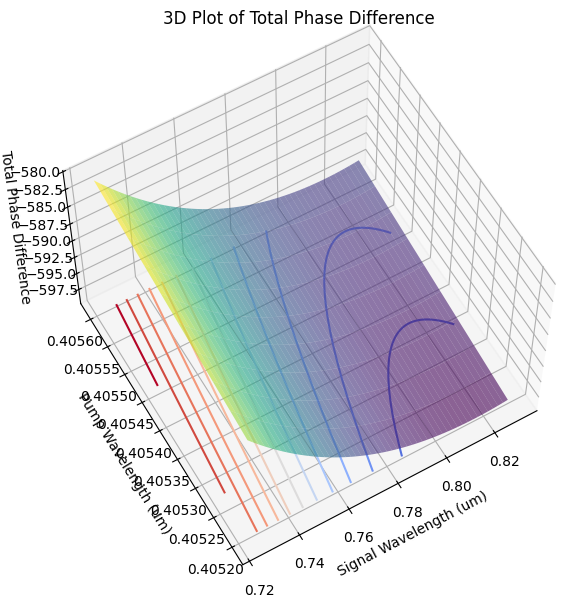

In [35]:
# Define optical path lengths (in um)
l_yvo_pre = 0 # 0.78e3
l_yvo_post = 0 # 0.97e3

l_calcite_pre = 12.5e3 # um
l_calcite_post = 13.3e3 # um

# Define polarization states
a = 'o'
aprime = 'e'
b = 'e'
bprime = 'o'

# Generate data for 3D plot
pump_wavelengths = np.linspace(0.4052, 0.4056, 10)
s_wavelengths = np.linspace(0.725, 0.83, 1000)
X, Y = np.meshgrid(s_wavelengths, pump_wavelengths)
Z = np.zeros_like(X)

for i, pump_wavelength in enumerate(pump_wavelengths):
    s_wavelengths = 1 / (1 / pump_wavelength - 1 / i_wavelengths)
    
    n_a_yvo_p = yvo_sellmeier_n(pump_wavelength, a)
    n_o_calcite_p = calcite_sellmeier_n(pump_wavelength, "o")
    n_eff_calcite_i = calcite_sellmeier_n_eff(i_wavelengths)
    n_eff_calcite_s = calcite_sellmeier_n_eff(s_wavelengths)
    n_b_yvo_i = yvo_sellmeier_n(i_wavelengths, b)
    n_b_yvo_s = yvo_sellmeier_n(s_wavelengths, b)
    n_aprime_yvo_p = yvo_sellmeier_n(pump_wavelength, aprime)
    n_eff_calcite_p = calcite_sellmeier_n_eff(pump_wavelength)
    n_o_calcite_i = calcite_sellmeier_n(i_wavelengths, "o")
    n_o_calcite_s = calcite_sellmeier_n(s_wavelengths, "o")
    n_bprime_yvo_i = yvo_sellmeier_n(i_wavelengths, bprime)
    n_bprime_yvo_s = yvo_sellmeier_n(s_wavelengths, bprime)

    phase_h = 2 * np.pi * (
        l_yvo_pre  * n_a_yvo_p   / pump_wavelength + 
        l_calcite_pre  * n_o_calcite_p   / pump_wavelength +
        l_calcite_post * n_eff_calcite_i / i_wavelengths +
        l_calcite_post * n_eff_calcite_s / s_wavelengths +
        l_yvo_post * n_b_yvo_i   / i_wavelengths +
        l_yvo_post * n_b_yvo_s   / s_wavelengths
    )

    phase_v = 2 * np.pi * (
        l_yvo_pre  * n_aprime_yvo_p / pump_wavelength + 
        l_calcite_pre  * n_eff_calcite_p    / pump_wavelength +
        l_calcite_post * n_o_calcite_i      / i_wavelengths +
        l_calcite_post * n_o_calcite_s      / s_wavelengths +
        l_yvo_post * n_bprime_yvo_i / i_wavelengths +
        l_yvo_post * n_bprime_yvo_s / s_wavelengths
    )
    
    Z[i, :] = phase_v - phase_h

# Create 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.6)
ax.set_xlabel("Signal Wavelength (um)")
ax.set_ylabel("Pump Wavelength (um)")
ax.set_zlabel("Total Phase Difference")
ax.set_title("3D Plot of Total Phase Difference")
ax.contour(X, Y, Z, levels=np.arange(Z.min(), Z.max(), 1.5), cmap='coolwarm', offset=Z.min())

# set the viewing angle
ax.view_init(60, 240)

plt.show()


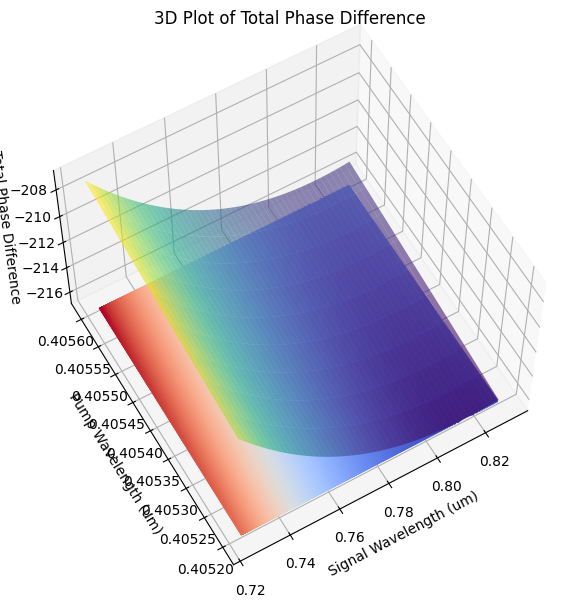

In [36]:
# Define optical path lengths (in um)
l_yvo_pre = 00.745e3
l_yvo_post = 00.795e3

l_calcite_pre = 12.5e3 # um
l_calcite_post = 13.3e3 # um

# Define polarization states
a = 'o'
aprime = 'e'
b = 'e'
bprime = 'o'

# Generate data for 3D plot
pump_wavelengths = np.linspace(0.4052, 0.4056, 10)
s_wavelengths = np.linspace(0.725, 0.83, 1000)
X, Y = np.meshgrid(s_wavelengths, pump_wavelengths)
Z = np.zeros_like(X)

for i, pump_wavelength in enumerate(pump_wavelengths):
    s_wavelengths = 1 / (1 / pump_wavelength - 1 / i_wavelengths)
    
    n_a_yvo_p = yvo_sellmeier_n(pump_wavelength, a)
    n_o_calcite_p = calcite_sellmeier_n(pump_wavelength, "o")
    n_eff_calcite_i = calcite_sellmeier_n_eff(i_wavelengths)
    n_eff_calcite_s = calcite_sellmeier_n_eff(s_wavelengths)
    n_b_yvo_i = yvo_sellmeier_n(i_wavelengths, b)
    n_b_yvo_s = yvo_sellmeier_n(s_wavelengths, b)
    n_aprime_yvo_p = yvo_sellmeier_n(pump_wavelength, aprime)
    n_eff_calcite_p = calcite_sellmeier_n_eff(pump_wavelength)
    n_o_calcite_i = calcite_sellmeier_n(i_wavelengths, "o")
    n_o_calcite_s = calcite_sellmeier_n(s_wavelengths, "o")
    n_bprime_yvo_i = yvo_sellmeier_n(i_wavelengths, bprime)
    n_bprime_yvo_s = yvo_sellmeier_n(s_wavelengths, bprime)

    phase_h = 2 * np.pi * (
        l_yvo_pre  * n_a_yvo_p   / pump_wavelength + 
        l_calcite_pre  * n_o_calcite_p   / pump_wavelength +
        l_calcite_post * n_eff_calcite_i / i_wavelengths +
        l_calcite_post * n_eff_calcite_s / s_wavelengths +
        l_yvo_post * n_b_yvo_i   / i_wavelengths +
        l_yvo_post * n_b_yvo_s   / s_wavelengths
    )

    phase_v = 2 * np.pi * (
        l_yvo_pre  * n_aprime_yvo_p / pump_wavelength + 
        l_calcite_pre  * n_eff_calcite_p    / pump_wavelength +
        l_calcite_post * n_o_calcite_i      / i_wavelengths +
        l_calcite_post * n_o_calcite_s      / s_wavelengths +
        l_yvo_post * n_bprime_yvo_i / i_wavelengths +
        l_yvo_post * n_bprime_yvo_s / s_wavelengths
    )
    
    Z[i, :] = phase_v - phase_h

# Create 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.6)
ax.set_xlabel("Signal Wavelength (um)")
ax.set_ylabel("Pump Wavelength (um)")
ax.set_zlabel("Total Phase Difference")
ax.set_title("3D Plot of Total Phase Difference")
ax.contour(X, Y, Z, levels=np.arange(Z.min(), Z.max(), 0.01), cmap='coolwarm', offset=Z.min())

z_range = Z.max() - Z.min()

# set the viewing angle
ax.view_init(60, 240)

plt.show()


In [37]:
# optimise to minimise the range over the yvo lengths
from scipy.optimize import minimize

def objective(x):
    l_yvo_pre, l_yvo_post = x
    l_calcite_pre = 12.5e3 # um
    l_calcite_post = 13.3e3 # um

    # Define polarization states
    a = 'o'
    aprime = 'e'
    b = 'e'
    bprime = 'o'

    # Generate data for 3D plot
    pump_wavelengths = np.linspace(0.4052, 0.4056, 10)
    s_wavelengths = np.linspace(0.725, 0.825, 1000)
    X, Y = np.meshgrid(s_wavelengths, pump_wavelengths)
    Z = np.zeros_like(X)

    for i, pump_wavelength in enumerate(pump_wavelengths):
        s_wavelengths = 1 / (1 / pump_wavelength - 1 / i_wavelengths)
        
        n_a_yvo_p = yvo_sellmeier_n(pump_wavelength, a)
        n_o_calcite_p = calcite_sellmeier_n(pump_wavelength, "o")
        n_eff_calcite_i = calcite_sellmeier_n_eff(i_wavelengths)
        n_eff_calcite_s = calcite_sellmeier_n_eff(s_wavelengths)
        n_b_yvo_i = yvo_sellmeier_n(i_wavelengths, b)
        n_b_yvo_s = yvo_sellmeier_n(s_wavelengths, b)
        n_aprime_yvo_p = yvo_sellmeier_n(pump_wavelength, aprime)
        n_eff_calcite_p = calcite_sellmeier_n_eff(pump_wavelength)
        n_o_calcite_i = calcite_sellmeier_n(i_wavelengths, "o")
        n_o_calcite_s = calcite_sellmeier_n(s_wavelengths, "o")
        n_bprime_yvo_i = yvo_sellmeier_n(i_wavelengths, bprime)
        n_bprime_yvo_s = yvo_sellmeier_n(s_wavelengths, bprime)

        phase_h = 2 * np.pi * (
            l_yvo_pre  * n_a_yvo_p   / pump_wavelength + 
            l_calcite_pre  * n_o_calcite_p   / pump_wavelength +
            l_calcite_post * n_eff_calcite_i / i_wavelengths +
            l_calcite_post * n_eff_calcite_s / s_wavelengths +
            l_yvo_post * n_b_yvo_i   / i_wavelengths +
            l_yvo_post * n_b_yvo_s   / s_wavelengths
        )

        phase_v = 2 * np.pi * (
            l_yvo_pre  * n_aprime_yvo_p / pump_wavelength + 
            l_calcite_pre  * n_eff_calcite_p    / pump_wavelength +
            l_calcite_post * n_o_calcite_i      / i_wavelengths +
            l_calcite_post * n_o_calcite_s      / s_wavelengths +
            l_yvo_post * n_bprime_yvo_i / i_wavelengths +
            l_yvo_post * n_bprime_yvo_s / s_wavelengths
        )
        
        Z[i, :] = phase_v - phase_h

    z_range = Z.max() - Z.min()

    return z_range

# pass the objective function to the minimiser
result = minimize(objective, [0.745e3, 0.795e3], method='Nelder-Mead')

# get the optimal lengths
l_yvo_pre, l_yvo_post = result.x

# print in mm
print(f"Optimal YVO4 lengths: {l_yvo_pre/1e3:.3f} mm, {l_yvo_post/1e3:.3f} mm")

Optimal YVO4 lengths: 1.529 mm, 1.682 mm


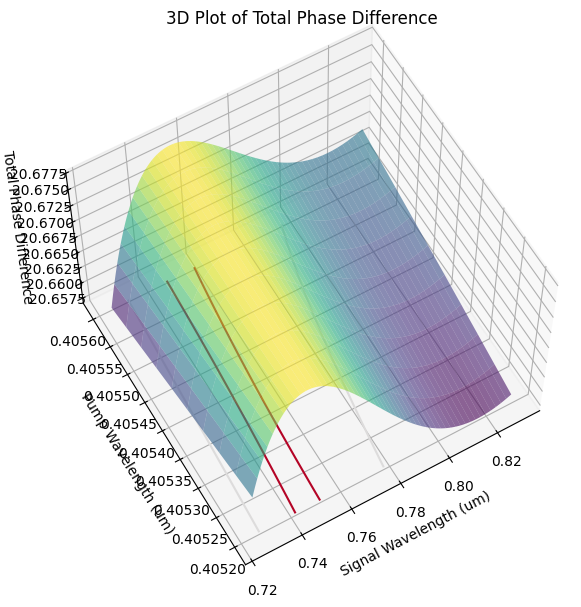

In [38]:
# Use the optimal lengths to generate the 3D plot

l_calcite_pre = 12.5e3 # um
l_calcite_post = 13.3e3 # um

# Define polarization states
a = 'o'
aprime = 'e'
b = 'e'
bprime = 'o'

# Generate data for 3D plot
pump_wavelengths = np.linspace(0.4052, 0.4056, 10)
s_wavelengths = np.linspace(0.725, 0.83, 1000)
X, Y = np.meshgrid(s_wavelengths, pump_wavelengths)
Z = np.zeros_like(X)

for i, pump_wavelength in enumerate(pump_wavelengths):
    s_wavelengths = 1 / (1 / pump_wavelength - 1 / i_wavelengths)
    
    n_a_yvo_p = yvo_sellmeier_n(pump_wavelength, a)
    n_o_calcite_p = calcite_sellmeier_n(pump_wavelength, "o")
    n_eff_calcite_i = calcite_sellmeier_n_eff(i_wavelengths)
    n_eff_calcite_s = calcite_sellmeier_n_eff(s_wavelengths)
    n_b_yvo_i = yvo_sellmeier_n(i_wavelengths, b)
    n_b_yvo_s = yvo_sellmeier_n(s_wavelengths, b)
    n_aprime_yvo_p = yvo_sellmeier_n(pump_wavelength, aprime)
    n_eff_calcite_p = calcite_sellmeier_n_eff(pump_wavelength)
    n_o_calcite_i = calcite_sellmeier_n(i_wavelengths, "o")
    n_o_calcite_s = calcite_sellmeier_n(s_wavelengths, "o")
    n_bprime_yvo_i = yvo_sellmeier_n(i_wavelengths, bprime)
    n_bprime_yvo_s = yvo_sellmeier_n(s_wavelengths, bprime)

    phase_h = 2 * np.pi * (
        l_yvo_pre  * n_a_yvo_p   / pump_wavelength + 
        l_calcite_pre  * n_o_calcite_p   / pump_wavelength +
        l_calcite_post * n_eff_calcite_i / i_wavelengths +
        l_calcite_post * n_eff_calcite_s / s_wavelengths +
        l_yvo_post * n_b_yvo_i   / i_wavelengths +
        l_yvo_post * n_b_yvo_s   / s_wavelengths
    )

    phase_v = 2 * np.pi * (
        l_yvo_pre  * n_aprime_yvo_p / pump_wavelength + 
        l_calcite_pre  * n_eff_calcite_p    / pump_wavelength +
        l_calcite_post * n_o_calcite_i      / i_wavelengths +
        l_calcite_post * n_o_calcite_s      / s_wavelengths +
        l_yvo_post * n_bprime_yvo_i / i_wavelengths +
        l_yvo_post * n_bprime_yvo_s / s_wavelengths
    )
    
    Z[i, :] = phase_v - phase_h

# Create 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.6)
ax.set_xlabel("Signal Wavelength (um)")
ax.set_ylabel("Pump Wavelength (um)")
ax.set_zlabel("Total Phase Difference")
ax.set_title("3D Plot of Total Phase Difference")
ax.contour(X, Y, Z, levels=np.arange(Z.min(), Z.max(), 0.01), cmap='coolwarm', offset=Z.min())

z_range = Z.max() - Z.min()

# set the viewing angle
ax.view_init(60, 240)

plt.show()


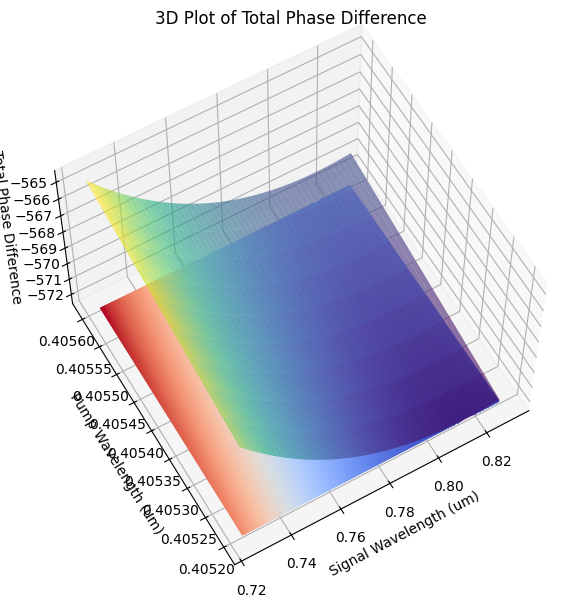

In [39]:
# Use the optimal lengths to generate the 3D plot
l_yvo_pre, l_yvo_post = (0.85e3, 1.03e3) # from original calculation

l_calcite_pre = 12.5e3 # um
l_calcite_post = 13.3e3 # um

# Define polarization states
a = 'o'
aprime = 'e'
b = 'e'
bprime = 'o'

# Generate data for 3D plot
pump_wavelengths = np.linspace(0.4052, 0.4056, 10)
s_wavelengths = np.linspace(0.725, 0.83, 1000)
X, Y = np.meshgrid(s_wavelengths, pump_wavelengths)
Z = np.zeros_like(X)

for i, pump_wavelength in enumerate(pump_wavelengths):
    s_wavelengths = 1 / (1 / pump_wavelength - 1 / i_wavelengths)
    
    n_a_yvo_p = yvo_sellmeier_n(pump_wavelength, a)
    n_o_calcite_p = calcite_sellmeier_n(pump_wavelength, "o")
    n_eff_calcite_i = calcite_sellmeier_n_eff(i_wavelengths)
    n_eff_calcite_s = calcite_sellmeier_n_eff(s_wavelengths)
    n_b_yvo_i = yvo_sellmeier_n(i_wavelengths, b)
    n_b_yvo_s = yvo_sellmeier_n(s_wavelengths, b)
    n_aprime_yvo_p = yvo_sellmeier_n(pump_wavelength, aprime)
    n_eff_calcite_p = calcite_sellmeier_n_eff(pump_wavelength)
    n_o_calcite_i = calcite_sellmeier_n(i_wavelengths, "o")
    n_o_calcite_s = calcite_sellmeier_n(s_wavelengths, "o")
    n_bprime_yvo_i = yvo_sellmeier_n(i_wavelengths, bprime)
    n_bprime_yvo_s = yvo_sellmeier_n(s_wavelengths, bprime)

    phase_h = 2 * np.pi * (
        l_yvo_pre  * n_a_yvo_p   / pump_wavelength + 
        l_calcite_pre  * n_o_calcite_p   / pump_wavelength +
        l_calcite_post * n_eff_calcite_i / i_wavelengths +
        l_calcite_post * n_eff_calcite_s / s_wavelengths +
        l_yvo_post * n_b_yvo_i   / i_wavelengths +
        l_yvo_post * n_b_yvo_s   / s_wavelengths
    )

    phase_v = 2 * np.pi * (
        l_yvo_pre  * n_aprime_yvo_p / pump_wavelength + 
        l_calcite_pre  * n_eff_calcite_p    / pump_wavelength +
        l_calcite_post * n_o_calcite_i      / i_wavelengths +
        l_calcite_post * n_o_calcite_s      / s_wavelengths +
        l_yvo_post * n_bprime_yvo_i / i_wavelengths +
        l_yvo_post * n_bprime_yvo_s / s_wavelengths
    )
    
    Z[i, :] = phase_v - phase_h

# Create 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.6)
ax.set_xlabel("Signal Wavelength (um)")
ax.set_ylabel("Pump Wavelength (um)")
ax.set_zlabel("Total Phase Difference")
ax.set_title("3D Plot of Total Phase Difference")
ax.contour(X, Y, Z, levels=np.arange(Z.min(), Z.max(), 0.01), cmap='coolwarm', offset=Z.min())

z_range = Z.max() - Z.min()

# set the viewing angle
ax.view_init(60, 240)

plt.show()


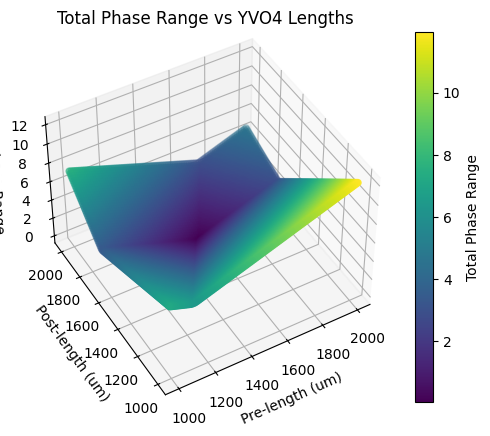

In [40]:
# Optimal YVO4 lengths: 1.529 mm, 1.682 mm

pre_length_range = np.linspace(1e3, 2e3, 100)
post_length_range = np.linspace(1e3, 2e3, 100)

Z = np.zeros((len(pre_length_range), len(post_length_range)))

range_data = []

for i, l_yvo_pre in enumerate(pre_length_range):
    for j, l_yvo_post in enumerate(post_length_range):
        
        l_calcite_pre = 12.5e3 # um
        l_calcite_post = 13.3e3 # um

        # Define polarization states
        a = 'o'
        aprime = 'e'
        b = 'e'
        bprime = 'o'

        # Generate data for 3D plot
        pump_wavelengths = np.linspace(0.4052, 0.4056, 10)
        s_wavelengths = np.linspace(0.725, 0.83, 1000)
        X, Y = np.meshgrid(s_wavelengths, pump_wavelengths)
        Z = np.zeros_like(X)

        for i, pump_wavelength in enumerate(pump_wavelengths):
            s_wavelengths = 1 / (1 / pump_wavelength - 1 / i_wavelengths)
            
            n_a_yvo_p = yvo_sellmeier_n(pump_wavelength, a)
            n_o_calcite_p = calcite_sellmeier_n(pump_wavelength, "o")
            n_eff_calcite_i = calcite_sellmeier_n_eff(i_wavelengths)
            n_eff_calcite_s = calcite_sellmeier_n_eff(s_wavelengths)
            n_b_yvo_i = yvo_sellmeier_n(i_wavelengths, b)
            n_b_yvo_s = yvo_sellmeier_n(s_wavelengths, b)
            n_aprime_yvo_p = yvo_sellmeier_n(pump_wavelength, aprime)
            n_eff_calcite_p = calcite_sellmeier_n_eff(pump_wavelength)
            n_o_calcite_i = calcite_sellmeier_n(i_wavelengths, "o")
            n_o_calcite_s = calcite_sellmeier_n(s_wavelengths, "o")
            n_bprime_yvo_i = yvo_sellmeier_n(i_wavelengths, bprime)
            n_bprime_yvo_s = yvo_sellmeier_n(s_wavelengths, bprime)

            phase_h = 2 * np.pi * (
                l_yvo_pre  * n_a_yvo_p   / pump_wavelength + 
                l_calcite_pre  * n_o_calcite_p   / pump_wavelength +
                l_calcite_post * n_eff_calcite_i / i_wavelengths +
                l_calcite_post * n_eff_calcite_s / s_wavelengths +
                l_yvo_post * n_b_yvo_i   / i_wavelengths +
                l_yvo_post * n_b_yvo_s   / s_wavelengths
            )

            phase_v = 2 * np.pi * (
                l_yvo_pre  * n_aprime_yvo_p / pump_wavelength + 
                l_calcite_pre  * n_eff_calcite_p    / pump_wavelength +
                l_calcite_post * n_o_calcite_i      / i_wavelengths +
                l_calcite_post * n_o_calcite_s      / s_wavelengths +
                l_yvo_post * n_bprime_yvo_i / i_wavelengths +
                l_yvo_post * n_bprime_yvo_s / s_wavelengths
            )
            
            Z[i, :] = phase_v - phase_h

        z_range = Z.max() - Z.min()

        range_data.append((l_yvo_pre, l_yvo_post, z_range))

range_data = np.array(range_data)

# plot the range data
fig = plt.figure()
# use a clear colourmap
cmap = plt.get_cmap('viridis')

ax = fig.add_subplot(111, projection='3d')
# add a colour bar to show the range
sc = ax.scatter(range_data[:, 0], range_data[:, 1], range_data[:, 2], c=range_data[:, 2], cmap=cmap)
fig.colorbar(sc, ax=ax, label="Total Phase Range")


ax.set_xlabel("Pre-length (um)")
ax.set_ylabel("Post-length (um)")
ax.set_zlabel("Total Phase Range")
ax.set_title("Total Phase Range vs YVO4 Lengths")


# set the viewing angle
ax.view_init(45, 240)

# save the plot
plt.savefig("calcite_range_plot.png")
